<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/experiment_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A basic task comparing an homogeneous to mixture of expert design

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Data generation
def generate_synthetic_data(num_samples=2000):
    """Generate synthetic sentiment analysis data"""
    texts = []
    labels = []

    # Positive templates
    positive_templates = [
        "This movie was {} with {} acting and {} plot",
        "An {} film that {} the audience with {} performances",
        "The director did {} work making this {} movie with {} scenes",
        "A {} masterpiece that {} viewers with {} moments",
        "The {} storytelling {} everyone with its {} narrative"
    ]

    # Negative templates
    negative_templates = [
        "This movie was {} with {} acting and {} plot",
        "A {} film that {} the audience with {} dialogue",
        "The director did {} work making this {} movie with {} scenes",
        "A {} disaster that {} viewers with {} moments",
        "The {} storytelling {} everyone with its {} narrative"
    ]

    # Word banks
    positive_words = {
        'adj': ['excellent', 'amazing', 'fantastic', 'wonderful', 'outstanding', 'brilliant', 'superb'],
        'verb': ['captivated', 'impressed', 'entertained', 'moved', 'delighted', 'inspired', 'pleased'],
        'desc': ['brilliant', 'masterful', 'powerful', 'beautiful', 'engaging', 'creative', 'innovative']
    }

    negative_words = {
        'adj': ['terrible', 'horrible', 'awful', 'disappointing', 'mediocre', 'poor', 'dreadful'],
        'verb': ['bored', 'annoyed', 'frustrated', 'disappointed', 'confused', 'angered', 'irritated'],
        'desc': ['poor', 'weak', 'dull', 'meaningless', 'confusing', 'chaotic', 'amateur']
    }

    for _ in range(num_samples):
        if np.random.random() > 0.5:
            template = np.random.choice(positive_templates)
            words = [np.random.choice(positive_words['adj']),
                    np.random.choice(positive_words['verb']),
                    np.random.choice(positive_words['desc'])]
            texts.append(template.format(*words))
            labels.append(1)
        else:
            template = np.random.choice(negative_templates)
            words = [np.random.choice(negative_words['adj']),
                    np.random.choice(negative_words['verb']),
                    np.random.choice(negative_words['desc'])]
            texts.append(template.format(*words))
            labels.append(0)

    return texts, labels

# Vocabulary processing
class Vocabulary:
    def __init__(self, max_size=10000):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        self.max_size = max_size

    def build_vocab(self, texts):
        # Count words
        for text in texts:
            self.word_freq.update(text.lower().split())

        # Add most common words to vocabulary
        for word, _ in self.word_freq.most_common(self.max_size - 2):  # -2 for PAD and UNK
            if word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word

    def text_to_indices(self, text, max_len=50):
        words = text.lower().split()
        indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]
        if len(indices) < max_len:
            indices += [self.word2idx['<PAD>']] * (max_len - len(indices))
        return indices[:max_len]

# Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Single Network
class SingleNetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout_rate=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim)

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)  # Average pooling over sequence length

        x = self.dropout(x)
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Expert Network
class ExpertNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Mixture of Experts
class MixtureOfExperts(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_experts, dropout_rate=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_experts = num_experts
        self.dropout = nn.Dropout(dropout_rate)

        self.experts = nn.ModuleList([
            ExpertNetwork(embedding_dim, hidden_dim, num_classes, dropout_rate)
            for _ in range(num_experts)
        ])

        self.gate = nn.Linear(embedding_dim, num_experts)
        self.gate_dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x_mean = x.mean(dim=1)
        x_mean = self.dropout(x_mean)

        gate_input = self.gate_dropout(x_mean)
        expert_weights = F.softmax(self.gate(gate_input), dim=-1)

        expert_outputs = []
        for expert in self.experts:
            expert_out = expert(x_mean)
            expert_outputs.append(expert_out)
        expert_outputs = torch.stack(expert_outputs, dim=1)

        weighted_outputs = expert_outputs * expert_weights.unsqueeze(-1)
        output = weighted_outputs.sum(dim=1)

        return output, expert_weights

    def get_balance_loss(self, expert_weights, eps=1e-10):
        expert_usage = expert_weights.mean(dim=0)
        target_usage = torch.ones_like(expert_usage) / self.num_experts
        balance_loss = F.kl_div(
            (expert_usage + eps).log(),
            target_usage,
            reduction='batchmean'
        )
        return balance_loss

Training Single Network:
Epoch 1/20:
Train Loss: 0.7232, Train Acc: 52.12%
Val Loss: 0.6598, Val Acc: 80.25%

Epoch 2/20:
Train Loss: 0.6834, Train Acc: 57.75%
Val Loss: 0.6057, Val Acc: 55.75%

Epoch 3/20:
Train Loss: 0.6317, Train Acc: 64.12%
Val Loss: 0.5235, Val Acc: 77.50%

Epoch 4/20:
Train Loss: 0.5620, Train Acc: 71.50%
Val Loss: 0.3912, Val Acc: 94.50%

Epoch 5/20:
Train Loss: 0.4500, Train Acc: 79.31%
Val Loss: 0.2254, Val Acc: 99.00%

Epoch 6/20:
Train Loss: 0.3391, Train Acc: 85.25%
Val Loss: 0.0979, Val Acc: 100.00%

Epoch 7/20:
Train Loss: 0.2436, Train Acc: 89.69%
Val Loss: 0.0465, Val Acc: 100.00%

Epoch 8/20:
Train Loss: 0.1622, Train Acc: 93.44%
Val Loss: 0.0204, Val Acc: 100.00%

Epoch 9/20:
Train Loss: 0.1098, Train Acc: 95.69%
Val Loss: 0.0222, Val Acc: 100.00%

Epoch 10/20:
Train Loss: 0.0705, Train Acc: 97.38%
Val Loss: 0.0054, Val Acc: 100.00%

Epoch 11/20:
Train Loss: 0.0505, Train Acc: 98.31%
Val Loss: 0.0053, Val Acc: 100.00%

Epoch 12/20:
Train Loss: 0.0458,

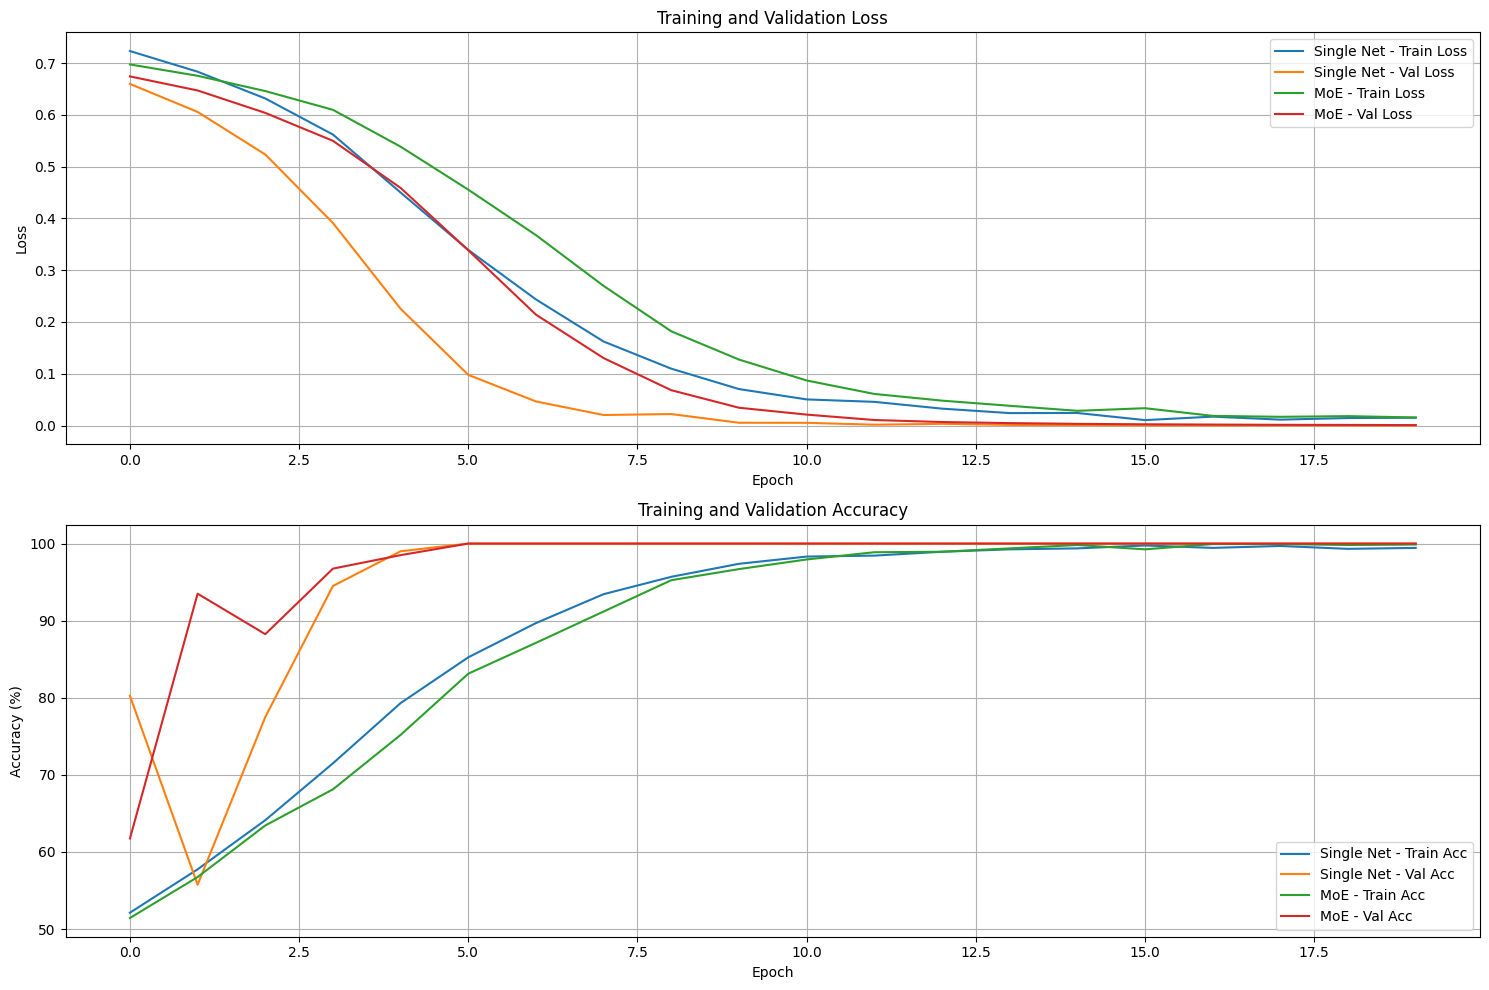

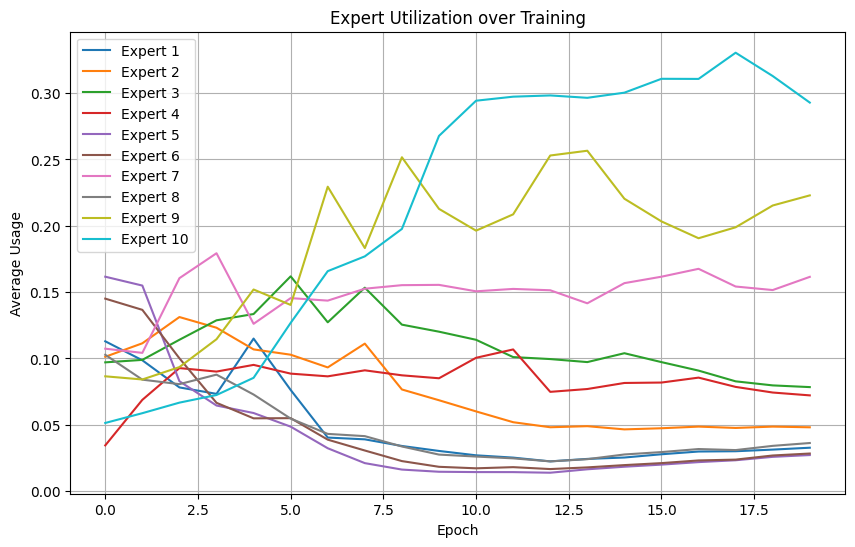


Single Network Predictions:
--------------------------------------------------------------------------------

Text: This movie was excellent with amazing acting and brilliant plot
Prediction: Positive
Confidence: 100.00%

Text: A terrible disaster that disappointed viewers with meaningless moments
Prediction: Negative
Confidence: 100.00%

Text: The creative storytelling impressed everyone with its innovative narrative
Prediction: Positive
Confidence: 99.93%

Text: This movie was horrible with poor acting and dull plot
Prediction: Negative
Confidence: 100.00%

Text: An outstanding film that captivated the audience with powerful performances
Prediction: Positive
Confidence: 100.00%

Mixture of Experts Predictions:
--------------------------------------------------------------------------------

Text: This movie was excellent with amazing acting and brilliant plot
Prediction: Positive
Confidence: 99.96%
Expert Contributions:
Expert 1: 0.033
Expert 2: 0.044
Expert 3: 0.078
Expert 4: 0.066

In [13]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20,
                balance_coeff=0.1, device='cuda'):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    expert_usage_stats = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()

            if isinstance(model, MixtureOfExperts):
                outputs, expert_weights = model(texts)
                loss = criterion(outputs, labels)
                balance_loss = model.get_balance_loss(expert_weights)
                total_loss = loss + balance_coeff * balance_loss

                if len(expert_usage_stats) <= epoch:
                    expert_usage_stats.append([])
                expert_usage_stats[epoch].append(expert_weights.mean(dim=0).detach().cpu().numpy())
            else:
                outputs = model(texts)
                total_loss = criterion(outputs, labels)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += total_loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)

                if isinstance(model, MixtureOfExperts):
                    outputs, expert_weights = model(texts)
                    loss = criterion(outputs, labels)
                else:
                    outputs = model(texts)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')

    return train_losses, val_losses, train_accs, val_accs, expert_usage_stats

def plot_results(single_results, moe_results):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(single_results[0], label='Single Net - Train Loss')
    plt.plot(single_results[1], label='Single Net - Val Loss')
    plt.plot(moe_results[0], label='MoE - Train Loss')
    plt.plot(moe_results[1], label='MoE - Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(single_results[2], label='Single Net - Train Acc')
    plt.plot(single_results[3], label='Single Net - Val Acc')
    plt.plot(moe_results[2], label='MoE - Train Acc')
    plt.plot(moe_results[3], label='MoE - Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)

    # Hyperparameters
    VOCAB_SIZE = 5000
    EMBEDDING_DIM = 128
    HIDDEN_DIM = 256
    NUM_CLASSES = 2
    NUM_EXPERTS = 10
    BATCH_SIZE = 64
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3

    # Generate data
    texts, labels = generate_synthetic_data(num_samples=2000)

    # Create vocabulary
    vocab = Vocabulary(max_size=VOCAB_SIZE)
    vocab.build_vocab(texts)

    # Convert texts to indices
    text_indices = [vocab.text_to_indices(text) for text in texts]

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        text_indices, labels, test_size=0.2, random_state=42
    )

    # Create datasets and dataloaders
    train_dataset = SentimentDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
    val_dataset = SentimentDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Train Single Network
    print("Training Single Network:")
    single_net = SingleNetwork(len(vocab.word2idx), EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, DROPOUT_RATE).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(single_net.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    single_results = train_model(single_net, train_loader, val_loader, criterion, optimizer,
                               num_epochs=NUM_EPOCHS, device=device)

    # Train Mixture of Experts
    print("\nTraining Mixture of Experts:")
    moe = MixtureOfExperts(
        len(vocab.word2idx),
        EMBEDDING_DIM,
        HIDDEN_DIM,
        NUM_CLASSES,
        NUM_EXPERTS,
        DROPOUT_RATE
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(moe.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    moe_results = train_model(
        moe,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=NUM_EPOCHS,
        device=device
    )

    # Plot results
    plot_results(single_results, moe_results)

    # Plot expert usage
    plt.figure(figsize=(10, 6))
    epoch_usage = [np.mean(epoch_stats, axis=0) for epoch_stats in moe_results[4]]
    epoch_usage = np.array(epoch_usage)

    for i in range(epoch_usage.shape[1]):
        plt.plot(epoch_usage[:, i], label=f'Expert {i+1}')

    plt.title('Expert Utilization over Training')
    plt.xlabel('Epoch')
    plt.ylabel('Average Usage')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test some example predictions
    def predict(model, text, vocab, device):
        model.eval()
        indices = vocab.text_to_indices(text)
        input_tensor = torch.LongTensor([indices]).to(device)

        with torch.no_grad():
            if isinstance(model, MixtureOfExperts):
                output, expert_weights = model(input_tensor)
                prob = torch.softmax(output, dim=1)
                prediction = prob.argmax(dim=1).item()
                confidence = prob.max(dim=1)[0].item()
                return prediction, confidence, expert_weights[0].cpu().numpy()
            else:
                output = model(input_tensor)
                prob = torch.softmax(output, dim=1)
                prediction = prob.argmax(dim=1).item()
                confidence = prob.max(dim=1)[0].item()
                return prediction, confidence, None

    # Test examples
    test_examples = [
        "This movie was excellent with amazing acting and brilliant plot",
        "A terrible disaster that disappointed viewers with meaningless moments",
        "The creative storytelling impressed everyone with its innovative narrative",
        "This movie was horrible with poor acting and dull plot",
        "An outstanding film that captivated the audience with powerful performances"
    ]

    print("\nSingle Network Predictions:")
    print("-" * 80)
    for text in test_examples:
        pred, conf, _ = predict(single_net, text, vocab, device)
        print(f"\nText: {text}")
        print(f"Prediction: {'Positive' if pred == 1 else 'Negative'}")
        print(f"Confidence: {conf*100:.2f}%")

    print("\nMixture of Experts Predictions:")
    print("-" * 80)
    for text in test_examples:
        pred, conf, expert_weights = predict(moe, text, vocab, device)
        print(f"\nText: {text}")
        print(f"Prediction: {'Positive' if pred == 1 else 'Negative'}")
        print(f"Confidence: {conf*100:.2f}%")
        print("Expert Contributions:")
        for i, weight in enumerate(expert_weights):
            print(f"Expert {i+1}: {weight:.3f}")